In [1]:
# Import warnings filter 
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Importing Dask packages
import dask.dataframe as dd
import dask.array as da

# Import other needed python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score

In [2]:
import os
import wget
# Extracting the dataset online
### To overwrite the previous datasets when re-running
if 'covid19_data.csv' in os.listdir("../data"):
    os.remove('/home/qwerty/Documents/Time Series Forecasting//data/covid19_data.csv')
    path = '/home/qwerty/Documents/Time Series Forecasting//data/covid19_data.csv'
    url =  "https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv"
    wget.download(url, path)
else:
    path = '/home/qwerty/Documents/Time Series Forecasting/data/covid19_data.csv'
    url =  "https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv"
    wget.download(url, path)
    
# Reading the dataset
data = dd.read_csv('../data/covid19_data.csv',
                   dtype={'Confirmed': 'float64','Deaths': 'float64', 'Recovered':'float64','Lat':'float64', 'long':'float64'})

### Preprocessing the datasets

In [3]:
data.head()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
1,2020-01-23,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
2,2020-01-24,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
3,2020-01-25,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
4,2020-01-26,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0


In [4]:
data.compute().describe()

,Lat,Long,Confirmed,Recovered,Deaths
count,35511.000000,35511.000000,3.537800e+04,33649.000000,35378.000000
mean,21.279064,22.055923,6.531770e+03,2349.077060,425.691390
std,24.908699,70.642913,5.527281e+04,15382.900815,3723.412346
min,-51.796300,-135.000000,-1.000000e+00,0.000000,-1.000000
25%,6.877000,-23.041800,0.000000e+00,0.000000,0.000000
50%,23.634500,20.939400,3.900000e+01,6.000000,0.000000
75%,41.204400,78.000000,6.107500e+02,197.000000,8.000000
max,71.706900,178.065000,1.831821e+06,463868.000000,106180.000000


In [5]:
data.compute().corr()

,Lat,Long,Confirmed,Recovered,Deaths
Lat,1.000000,-0.134332,0.067674,0.088209,0.081121
Long,-0.134332,1.000000,-0.065405,-0.051374,-0.071676
Confirmed,0.067674,-0.065405,1.000000,0.839709,0.931154
Recovered,0.088209,-0.051374,0.839709,1.000000,0.795156
Deaths,0.081121,-0.071676,0.931154,0.795156,1.000000


In [6]:
data.compute().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35511 entries, 0 to 35510
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            35511 non-null  object 
 1   Country/Region  35511 non-null  object 
 2   Province/State  10906 non-null  object 
 3   Lat             35511 non-null  float64
 4   Long            35511 non-null  float64
 5   Confirmed       35378 non-null  float64
 6   Recovered       33649 non-null  float64
 7   Deaths          35378 non-null  float64
dtypes: float64(5), object(3)
memory usage: 2.2+ MB


In [7]:
#Parsing the 'Date' feature to a date datatype 
data['Date'] = dd.to_datetime(data['Date'], infer_datetime_format=True) 

In [8]:
data.compute().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35511 entries, 0 to 35510
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            35511 non-null  datetime64[ns]
 1   Country/Region  35511 non-null  object        
 2   Province/State  10906 non-null  object        
 3   Lat             35511 non-null  float64       
 4   Long            35511 non-null  float64       
 5   Confirmed       35378 non-null  float64       
 6   Recovered       33649 non-null  float64       
 7   Deaths          35378 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 2.2+ MB


In [9]:
# Feature Engineering
data['CurrentCase'] = data['Confirmed'] - data['Recovered'] - data['Deaths']

In [10]:
data.head()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths,CurrentCase
0,2020-01-22,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0,0.0
1,2020-01-23,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0,0.0
2,2020-01-24,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0,0.0
3,2020-01-25,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0,0.0
4,2020-01-26,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0,0.0


In [11]:
# Aggregating all cases in the world and grouping by date
date_df = data.groupby('Date')[['Confirmed' ,'Recovered', 'Deaths', 'CurrentCase']].sum()

In [12]:
date_df.head()

,Confirmed,Recovered,Deaths,CurrentCase
Date,,,,
2020-01-22,555.0,28.0,17.0,510.0
2020-01-23,654.0,30.0,18.0,606.0
2020-01-24,941.0,36.0,26.0,879.0
2020-01-25,1434.0,39.0,42.0,1353.0
2020-01-26,2118.0,52.0,56.0,2009.0


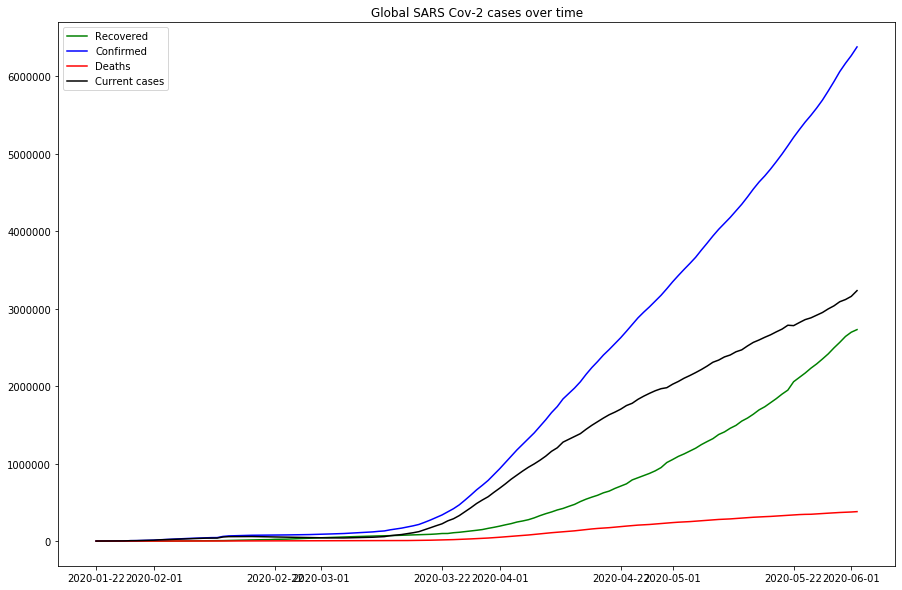

In [13]:
plt.figure(figsize=(15,10))
plt.plot(date_df["Recovered"].compute(),color='g',label='Recovered')
plt.plot(date_df["Confirmed"].compute(),color='b', label='Confirmed')
plt.plot(date_df["Deaths"].compute(),color='r',label='Deaths')
plt.plot(date_df['CurrentCase'].compute(),color='k', label='Current cases')
plt.title('Global SARS Cov-2 cases over time')
plt.legend();

In [14]:
# Model initialization
from fbprophet import Prophet
model = Prophet()

In [15]:
# Add seasonality
model.add_seasonality(name='Monthly', period=30.42, fourier_order=5)

In [16]:
### Splitting datasets operation
global_cases = date_df.reset_index()
confirmed_df = global_cases[['Date', 'Confirmed']]
recovered_df = global_cases[['Date', 'Recovered']]
deaths_df = global_cases[['Date', 'Deaths']]
current_df = global_cases[['Date', 'CurrentCase']]

In [17]:
# For Prophet to predict, its required for the names on the variables to be ds and y
def rename_func(dataframe):
    cols = dataframe.columns
    dataframe = dataframe.rename(columns= {cols[0]: 'ds', cols[1]:'y'})
    return dataframe

In [18]:
confirmed_df = rename_func(confirmed_df)
recovered_df = rename_func(recovered_df)
deaths_df = rename_func(deaths_df)
current_df = rename_func(current_df)

In [19]:
# Get overview of changes
confirmed_df.head()

,ds,y
0,2020-01-22,555.0
1,2020-01-23,654.0
2,2020-01-24,941.0
3,2020-01-25,1434.0
4,2020-01-26,2118.0


In [20]:
def train_test_split(dataframe, ratio):
    """
    Parameters:
    dataframe- Dataframe required to be split
    ratio: Percentage of training split in the scale of 0-100
    """
    divisor = round((ratio/100)*dataframe.compute().shape[0])
    #print(f'Division occurs at index {divisor}')
    train = dataframe.compute().iloc[:divisor]
    test = dataframe.compute().iloc[divisor:]
    return train, test, divisor

### Confirmed cases Prediction operations

In [21]:
confirmed_train, confirmed_test, divisor = train_test_split(confirmed_df, 70)

In [22]:
confirmed_train.shape, confirmed_test.shape

((93, 2), (40, 2))

In [23]:
# Fitting model
model.fit(confirmed_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [24]:
# Creating future dates
future_dates = model.make_future_dataframe(periods=40)

In [25]:
# Making predictions
predictions = model.predict(future_dates)

In [26]:
predictions.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Monthly,Monthly_lower,Monthly_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,-1261.873570,-5180.082718,2353.500816,-1261.873570,-1261.873570,4108.494492,4108.494492,4108.494492,30.744752,30.744752,30.744752,-4077.749740,-4077.749740,-4077.749740,0.0,0.0,0.0,-1231.128817
1,2020-01-23,-1657.910169,-3553.865839,3540.764082,-1657.910169,-1657.910169,1805.590711,1805.590711,1805.590711,1729.955438,1729.955438,1729.955438,-75.635273,-75.635273,-75.635273,0.0,0.0,0.0,72.045269
2,2020-01-24,-2053.946767,-1846.697359,5717.675667,-2053.946767,-2053.946767,1092.396707,1092.396707,1092.396707,4047.813382,4047.813382,4047.813382,2955.416675,2955.416675,2955.416675,0.0,0.0,0.0,1993.866615
3,2020-01-25,-2449.983366,-1811.042203,5346.855685,-2449.983366,-2449.983366,1615.539805,1615.539805,1615.539805,4181.014633,4181.014633,4181.014633,2565.474828,2565.474828,2565.474828,0.0,0.0,0.0,1731.031267
4,2020-01-26,578.027498,2022.392412,8818.816576,578.027498,578.027498,2269.709431,2269.709431,2269.709431,4925.078446,4925.078446,4925.078446,2655.369015,2655.369015,2655.369015,0.0,0.0,0.0,5503.105944


In [27]:
predictions.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Monthly', 'Monthly_lower', 'Monthly_upper', 'additive_terms',
       'additive_terms_lower', 'additive_terms_upper', 'weekly',
       'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [28]:
predictions.yhat.head()

0   -1231.128817
1      72.045269
2    1993.866615
3    1731.031267
4    5503.105944
Name: yhat, dtype: float64

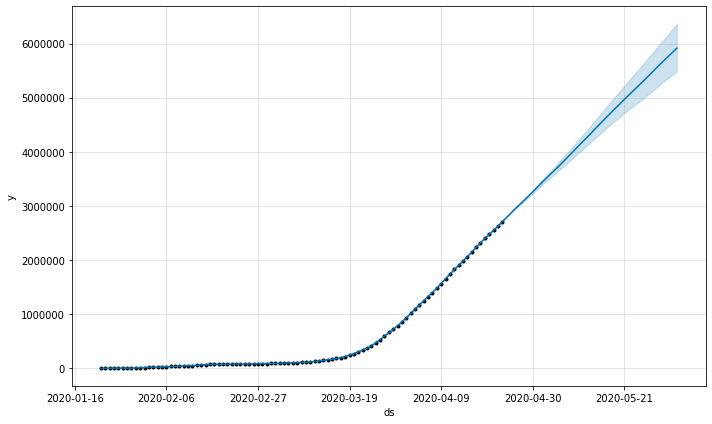

In [29]:
model.plot(predictions);

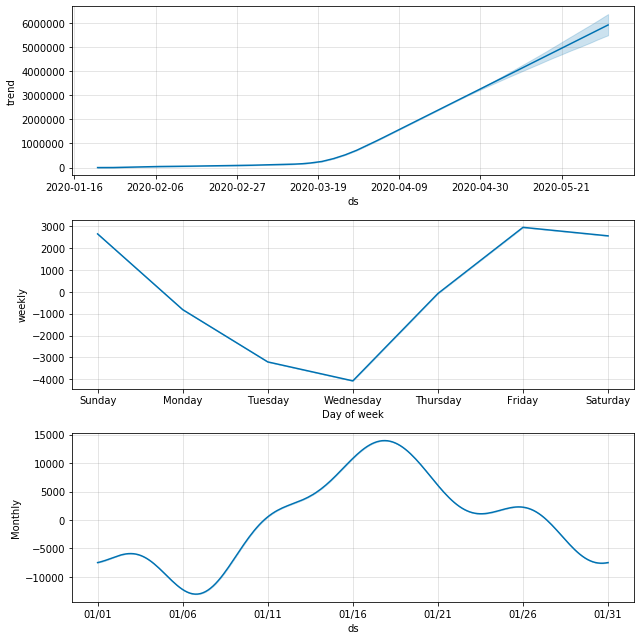

In [30]:
model.plot_components(predictions);

In [31]:
def check_metrics(test, predictions):
    R2_score = r2_score(test['y'],predictions['yhat'].iloc[divisor:])
    print(f"R-square Score: {R2_score}")

In [32]:
check_metrics(confirmed_test, predictions)

R-square Score: 0.9722947182683824


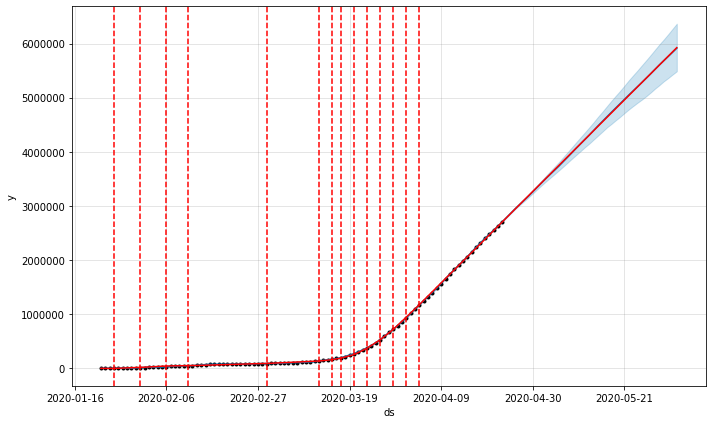

In [33]:
from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(predictions)
changes = add_changepoints_to_plot(fig.gca(), model, predictions)

In [34]:
def determinate_beta_gamma_delta(data=None):
    '''
        this function compute transmission rate, recovered rate and fatalities rate over time
        params: data
        return: beta, gamma, delta
    '''
    
    beta = []
    gamma = []
    delta = []
    
    for t in range(len(data.Date.compute().values)):
        
        x = data.Confirmed.compute().iloc[t]
        y = data.Deaths.compute().iloc[t]
        z = data.Recovered.compute().iloc[t]
        w = data.CurrentCase.compute().iloc[t]
        
        if x == 0.0:
            beta.append(0)
            gamma.append(0)
            delta.append(0)
        else:
            beta_t = w/x
            gamma_t = z/x
            delta_t = y/x
            
            beta.append(beta_t)
            gamma.append(gamma_t)
            delta.append(delta_t)
            
    return np.array(beta), np.array(gamma), np.array(delta)        

In [35]:
transmission, recovery, fatality = determinate_beta_gamma_delta(data=global_cases)

In [36]:
parameter_dynamic = pd.DataFrame()
parameter_dynamic['beta'] = transmission
parameter_dynamic['gamma'] = recovery
parameter_dynamic['delta'] = fatality
parameter_dynamic['Date'] = global_cases.Date
parameter_dynamic = parameter_dynamic.set_index('Date')

In [37]:
parameter_dynamic.head()

,beta,gamma,delta
Date,,,
2020-01-22,0.918919,0.050450,0.030631
2020-01-23,0.926606,0.045872,0.027523
2020-01-24,0.934113,0.038257,0.027630
2020-01-25,0.943515,0.027197,0.029289
2020-01-26,0.948536,0.024551,0.026440


In [38]:
def find_R0(data=None):
    '''
        This function compute R0 over time
        params: data
        return: R0
    '''
    return data.beta.values/(data.gamma.values + data.delta.values)

In [39]:
#Compute R0
parameter_dynamic['R0'] = find_R0(data=parameter_dynamic)
print(parameter_dynamic['R0'].min())
parameter_dynamic.columns=['\u03B2', '\u03B3', '\u03B4','R0']
parameter_dynamic.columns

0.7019303822001705


Index(['β', 'γ', 'δ', 'R0'], dtype='object')

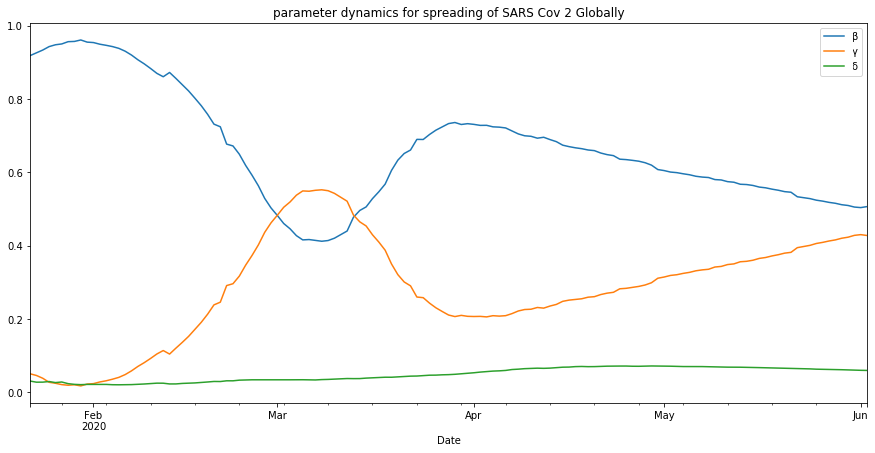

In [40]:
parameter_dynamic[['\u03B2', '\u03B3', '\u03B4']].plot(figsize=(15,7))
plt.legend(loc='best')
plt.title('parameter dynamics for spreading of SARS Cov 2 Globally');

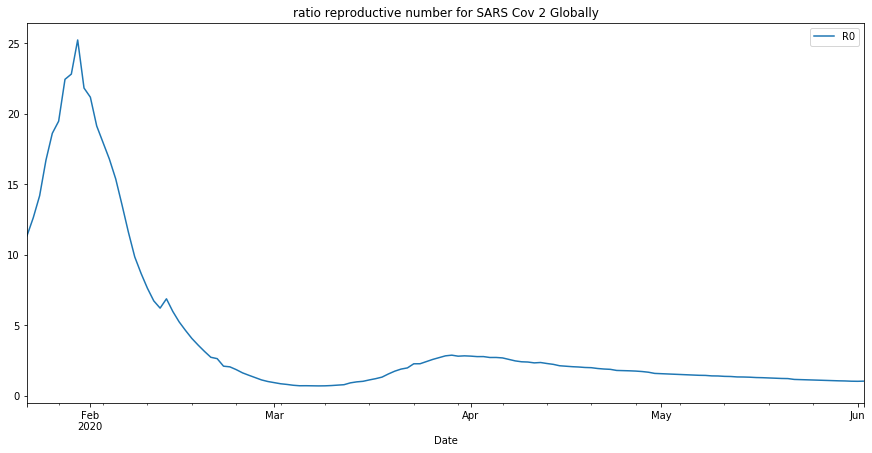

In [41]:
# Plot R0
parameter_dynamic['R0'].plot(figsize=(15,7))
plt.legend(loc='best')
plt.title('ratio reproductive number for SARS Cov 2 Globally');

In [42]:
def growth_rate(data=None):
    """
        This function compute a growth rate of one variable
        params: data
        return: growth rate x
    
    """
    x = []
    x.append(0)
    for i in range(data.compute().shape[0]-1):
        a = data.compute().iloc[i+1]-data.compute().iloc[i]
        b = a/data.compute().iloc[i]
        x.append(b)
        
    return np.array(x)

In [43]:
growth_rate_currentCase = pd.DataFrame(growth_rate(data=global_cases.CurrentCase), columns=['currentCase'])

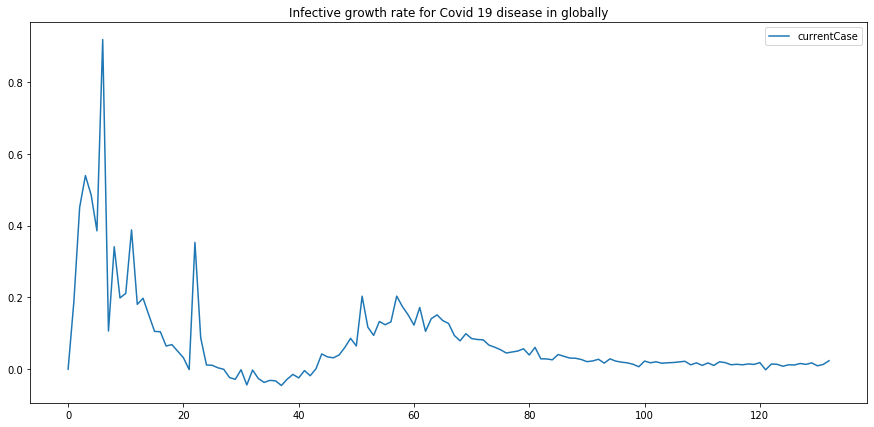

In [44]:
growth_rate_currentCase.plot(figsize=(15,7))
plt.legend(loc='best')
plt.title('Infective growth rate for Covid 19 disease in globally');